In [76]:
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt

torch.__version__

'2.4.0+cu124'

Let's make a simple model. Here's what the general workflow of making a model is like:

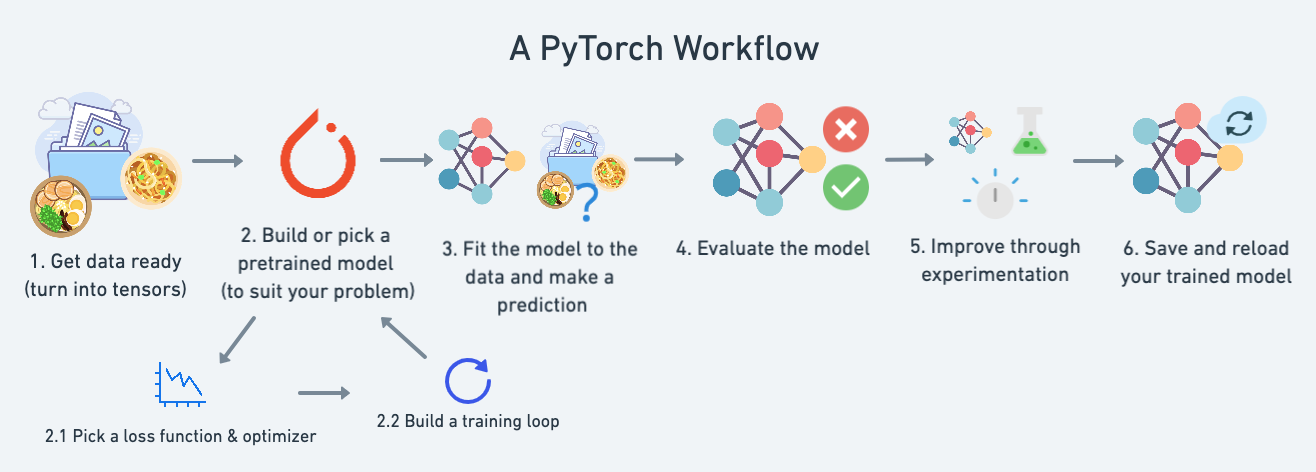

The data processed by an ML model can literally be anything as long as it can be described with numbers

### 1. Create model

Let's try to make a straight line that is predicted by the model using linear regression.

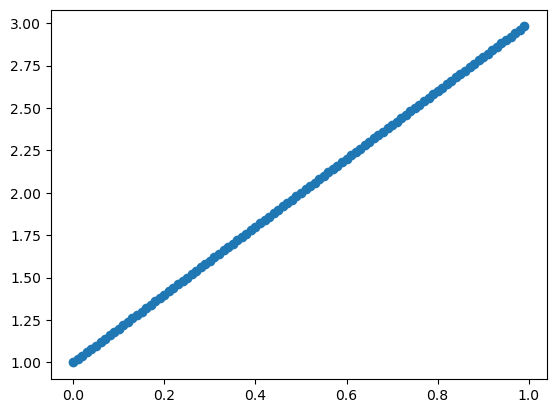

In [77]:
# create arbitrary linear function parameters
m = 2
b = 1

# make data
X = torch.arange(0, 1, 0.01).unsqueeze(dim=1)
y = m * X + b

plt.plot(X, y, "o")
plt.show()

With this data, we split into training and test datasets

In [78]:
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

Visualize the data

In [79]:
def plot_predictions(train_data=X_train,
                     train_label=y_train,
                     test_data=X_test,
                     test_label=y_test,
                     predictions=None):
    
    # plot training data points
    plt.scatter(train_data, train_label, c="b", s=6, label="Training Data")

    # plot test data points
    plt.scatter(test_data, test_label, c="r", s=6, label="Test Data")

    # plot with predictions from model
    if predictions is not None:
        plt.scatter(test_data, predictions, c="g", s=6, label="Predictions")

    plt.legend(prop={"size": 14})

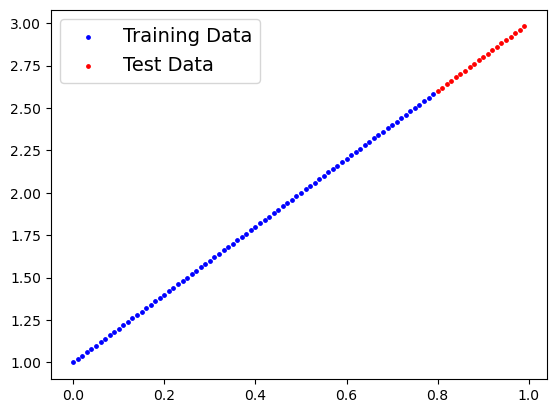

In [80]:
plot_predictions()

### 2. Build Model

With the data initialized, create a model to predict the datapoints as best as possible. A good algorithm for this would be linear regression which can be created through PyTorch's library

In [81]:
class LinearRegressionModel(nn.Module): # always use nn.Module; this is the basis of creating neural networks in pytorch
    def __init__(self):

        # get everything from nn.Module
        super().__init__()

        # initialize parameters
        self.weights = nn.Parameter(torch.randn(1, # one weight (like the m in mx+b)
                                                dtype=torch.float, # default dtype
                                                requires_grad=True # set true for if value wants gradient descent
                                                ))
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float, requires_grad=True))

    # define forward pass in model
    def forward(self, x:torch.Tensor) -> torch.Tensor: # x here is the x from training or test dataset
        return self.weights * x + self.bias # linear regression equation

There are some things that are from nn. These are basically the building blocks of making virtually any neural network in PyTorch.

| PyTorch Module | Function |
| --- | --- |
| `torch.nn` | The core building block for computations
| `torch.nn.Parameter` | Accepts and stores tensors for `nn.Module`. If `requires_grad=True` then gradients which are used to update values are automatically calculated (this is called autograd)
| `nn.Module` | The base for all neural networks. All neural networks are subclasses of `nn.Module` Needs a `forward()` to be implemented
| `torch.optim` | Has various optimization algorithms for in `nn.Parameter` on how to best optimize its value through improving gradient descent and decreasing loss
| `forward()` | Mandatory `nn.Module` function that defines the forward pass of the model

With the model created, we check its contents (e.g. parameters)

In [82]:
# set manual seed since making the model creates rng
torch.manual_seed(69)

# create model
model = LinearRegressionModel()

# check parameters in model
list(model.parameters())

[Parameter containing:
 tensor([-0.5259], requires_grad=True),
 Parameter containing:
 tensor([-2.6043], requires_grad=True)]

In [83]:
# check state (what the model contains; parameters with its names)
model.state_dict()

OrderedDict([('weights', tensor([-0.5259])), ('bias', tensor([-2.6043]))])

Notice that the numbers generated are random since we want the model to optimized after each forward pass and gradient descent to improve those numbers. For now with those numbers, the model will predict horribly.

For now we make a prediction to test the model using X_test and see if it predicts close to y_label

In [84]:
# make predictions with model
with torch.inference_mode(): # in older pytorch code, inference_mode is no_grad()
    y_pred = model(X_test)

Using `torch.inference_mode()`, the model undergoes inference (forward-pass). It turns off multiple things like gradient tracking to make it go fast

Let's see how well the model predicted

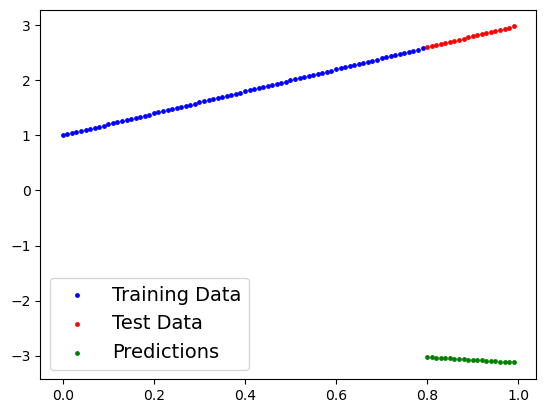

In [85]:
plot_predictions(predictions=y_pred)

Yeah that's bad. But expected since the model really is just rng and it hasn't even looked at the training dataset at all.

### 3. Train Model

The model currently uses rng values and predicts badly. Using loss functions and optimizers to evaluate the model and gradient descent to change values is necessary to improve the model.

First create a loss function to evaluate the model as well as an optimizer:

| Evaluation | Function | Where in PyTorch? | Common examples
| --- | --- | --- | --- |
Loss function | Measures how wrong the model is with predicted y and test y | Plenty in `torch.nn` | Mean squared error (MSE) for regression `torch.nn.MSELoss()`. Binary cross entropy for binary classification `torch.nn.BCELoss()`
Optimizer | Tells model how to update parameters to minimize loss | A bunch of it is in `torch.optim` | Stochastic gradient descent (SGD) `torch.optim.SGD()` and Adam `torch.optim.Adam()`

Choose MSE because we're predicting numbers and SGD flor optimizer

In [86]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(params=model.parameters(), # parameters of the model
                            lr = 0.01) # learning rate on how much the model's parameters change (typically 0.01, 0.1 or 0.001)

Make the model undergo a training loop and a testing loop which will change the values of the parameters that will hopefully minimze loss.

The training loop comprises of several steps:
1. Forward pass `model(X_train)`: Goes through all the data once and performs `forward()`
2. Calculates loss `loss = loss_fn(y_pred, y_train)`: Calculates how far away the model is from the actual labels
3. Zero gradients `optimizer.zero_grad()`: Set gradients to zero so it can be recalculated again per training step (no unnecessary tracking values)
4. Perform backpropagation `loss.backward()`: Computes loss gradient with parameter values for parameters to be updated (all with `requires_grad=True`)
5. Update optimizer `optimizer.step()`: Update `requires_grad=True` parameters with computed value from previous step 

The testing loop comprises of fewer steps for evaluation:
1. Forward pass `model(X_test)`: Model undergoes all test data and performs `forward()`
2. Calculate loss `loss = loss_fn(y_pred, y_test)`: Calculates how far away the model is from actual labels in testing dataset
3. Calculate evaluation metrics (custom): Other than seeing loss, it is also important to see other metrics on how the model performed such as accuracy.

The testing loop does not have backpropagation or optimizer because it does not change values of the model anymore because it is testing the values done in the training loop

You can put both the training and testing loop in the same loop

In [108]:
# set seed
torch.manual_seed(69)

# set no of times the model sees the entire dataset
epochs = 100

# create lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):

    ### TRAINING

    # 1. Forward pass
    y_pred = model(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero gradient
    optimizer.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. Update optimizer
    optimizer.step()


    ### TESTING

    # set model into evaluation mode
    model.eval()

    with torch.inference_mode():

        # 1. forward pass
        test_pred = model(X_test)

        # 2. calculate loss on test dataset
        test_loss = loss_fn(test_pred, y_test)

        # print out loss
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy()) # turn into numpy datatype
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MSE Train: {loss} | MSE Test: {test_loss}")

Epoch: 0 | MSE Train: 0.0018503295723348856 | MSE Test: 0.008074899204075336
Epoch: 10 | MSE Train: 0.0018167035887017846 | MSE Test: 0.007928158156573772
Epoch: 20 | MSE Train: 0.001783688785508275 | MSE Test: 0.007784040179103613
Epoch: 30 | MSE Train: 0.001751272357068956 | MSE Test: 0.007642584852874279
Epoch: 40 | MSE Train: 0.0017194468528032303 | MSE Test: 0.0075037009082734585
Epoch: 50 | MSE Train: 0.0016881966730579734 | MSE Test: 0.007367300800979137
Epoch: 60 | MSE Train: 0.0016575154149904847 | MSE Test: 0.007233383599668741
Epoch: 70 | MSE Train: 0.0016273928340524435 | MSE Test: 0.007101925555616617
Epoch: 80 | MSE Train: 0.001597817987203598 | MSE Test: 0.006972876843065023
Epoch: 90 | MSE Train: 0.0015687771374359727 | MSE Test: 0.006846189498901367


You know the model is working because the loss is going down. Let's visualize it.

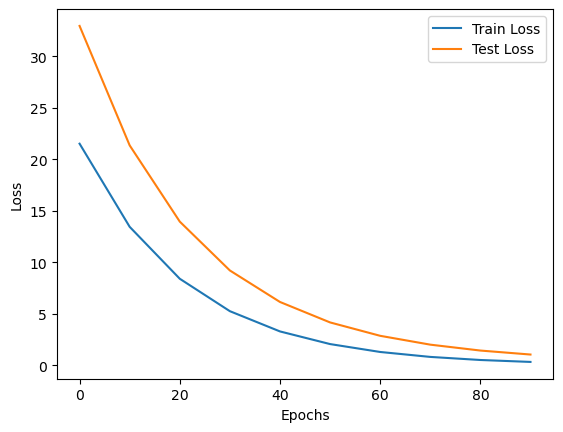

In [88]:
plt.plot(epoch_count, train_loss_values, label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")

plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

With this low loss, we can assume that the model has gotten quite close to the actual parameters for the data in the very first line of code. Let's check that

In [89]:
print(f"Real weights and loss: {m}, {b}")
print("What the model predicted:")
print(model.state_dict())

Real weights and loss: 2, 1
What the model predicted:
OrderedDict([('weights', tensor([1.0388])), ('bias', tensor([0.9565]))])


As you can see it's not perfectly like the arbitrarily defined values but close enough that it maintains a good loss. Usually a model undergoes many epochs until it converges (loss difference per epoch is trivial). More epochs = more training = less loss

### 4. Predict with Model

Predicting with the model (inference) is similar to the testing loop executed above. Make sure to do three things:
1. Set the model in evaluation mode `model.eval()`
2. Make predictions with inference mode `with torch.inference_mode():`
3. All predictions are made with same objects on same device (e.g. data and model with GPU; data and model with CPU)

In [109]:
# 1. Set model in evaluation mode
model.eval()

# 2. Use inference mode
with torch.inference_mode():
    y_preds = model(X_test)

y_preds

tensor([[2.5346],
        [2.5529],
        [2.5712],
        [2.5895],
        [2.6078],
        [2.6261],
        [2.6445],
        [2.6628],
        [2.6811],
        [2.6994],
        [2.7177],
        [2.7360],
        [2.7543],
        [2.7726],
        [2.7909],
        [2.8092],
        [2.8275],
        [2.8458],
        [2.8641],
        [2.8824]])

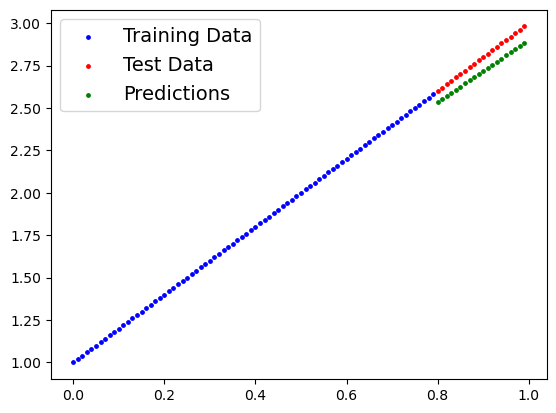

In [110]:
plot_predictions(predictions=y_preds)

If you set to more epochs the green dots should be very close to the red dots.

### 5. Saving and Loading Model